In [767]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go


# Exploratory Data Analysis on Demo Data

__Objective__

The objective of the file is to go through a simple EDA process mainly focused on Time Series Forecasting for predicting sales.

In [768]:
# File path
data_flav_weather_path = '/Users/lucazosso/Desktop/IE_Course/weclomeback/welcomeback_dev/data_science_folder/cleaned/hourly_orders_weather_flavoured.csv'
df = pd.read_csv(data_flav_weather_path)
print(df.shape)
df.iloc[0, :]

(12968, 26)


datetime                         2023-04-24 08:28:21+00:00
order_id                                            138981
postcode                                              6928
day_of_week                                         Monday
tot_orders                                               1
tot_gross_revenue                                     49.0
tot_cogs                                               9.3
tot_orders_marketplace                                   1
tot_orders_int                                           0
tot_orders_b2b                                           0
tot_gross_revenue_mrktpl                              49.0
tot_gross_revenue_int                                  0.0
tot_gross_revenue_b2b                                  0.0
AOV                                                   49.0
lag_weekday_tot_orders                                 1.0
lag_weekday_tot_gross_revenue                        16.72
lag_weekday_AOV                                      16.

In [769]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12968 entries, 0 to 12967
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   datetime                       12968 non-null  object 
 1   order_id                       12968 non-null  int64  
 2   postcode                       12961 non-null  object 
 3   day_of_week                    12968 non-null  object 
 4   tot_orders                     12968 non-null  int64  
 5   tot_gross_revenue              12968 non-null  float64
 6   tot_cogs                       12901 non-null  float64
 7   tot_orders_marketplace         12968 non-null  int64  
 8   tot_orders_int                 12968 non-null  int64  
 9   tot_orders_b2b                 12968 non-null  int64  
 10  tot_gross_revenue_mrktpl       12968 non-null  float64
 11  tot_gross_revenue_int          12968 non-null  float64
 12  tot_gross_revenue_b2b          12968 non-null 

## Data cleaning

Here the objective is to rename some columns, remove some others

WMO Weather Code: https://open-meteo.com/en/docs/historical-weather-api#latitude=47.0002&longitude=8.0143&hourly=temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,sunshine_duration&daily=&timezone=auto

In [770]:
# Rename tot_orders columns tta should be a boolean
renamed_cols = {'tot_orders_marketplace':'is_order_marketplace',
                'tot_orders_int': 'is_order_website',
                'tot_orders_b2b': 'is_order_b2b',
                }
df.rename(columns=renamed_cols, inplace=True)
# Delete some columns that were badly computed in the SQL statement
cols_to_drop = ['tot_orders', 'tot_gross_revenue_mrktpl', 'tot_gross_revenue_int', 
                'tot_gross_revenue_b2b', 'AOV','lag_weekday_tot_orders','lag_weekday_tot_gross_revenue',
                'lag_weekday_AOV']


df.drop(columns=cols_to_drop, inplace=True)

# Create is_weekend column
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)


__Map weather code for interpreatbility__

In [771]:
from datetime import datetime, timedelta
import pytz  # For timezone handling

weather_data = {
    "0": {"day": {"description": "Sunny"}, "night": {"description": "Clear"}},
    "1": {"day": {"description": "Mainly Sunny"}, "night": {"description": "Mainly Clear"}},
    "2": {"day": {"description": "Partly Cloudy"}, "night": {"description": "Partly Cloudy"}},
    "3": {"day": {"description": "Cloudy"}, "night": {"description": "Cloudy"}},
    "51": {"day": {"description": "Light Drizzle"}, "night": {"description": "Light Drizzle"}},
    "53": {"day": {"description": "Drizzle"}, "night": {"description": "Drizzle"}},
    "55": {"day": {"description": "Heavy Drizzle"}, "night": {"description": "Heavy Drizzle"}},
    "61": {"day": {"description": "Light Rain"}, "night": {"description": "Light Rain"}},
    "63": {"day": {"description": "Rain"}, "night": {"description": "Rain"}},
    "65": {"day": {"description": "Heavy Rain"}, "night": {"description": "Heavy Rain"}},
    "71": {"day": {"description": "Light Snow"}, "night": {"description": "Light Snow"}},
    "73": {"day": {"description": "Snow"}, "night": {"description": "Snow"}},
    "75": {"day": {"description": "Heavy Snow"}, "night": {"description": "Heavy Snow"}},
}

swiss_timezone = pytz.timezone("Europe/Zurich")
# Adding weather description to DataFrame based on the time of day
def get_weather_description(row):
    # Ensure the datetime is recognized as a datetime object
    if isinstance(row['datetime'], str):
        row['datetime'] = pd.to_datetime(row['datetime'])
    swiss_time = row['datetime'].astimezone(swiss_timezone)
    time_of_day = "day" if 6 <= swiss_time.hour < 18 else "night"
    code_str = str(int(row['weather_code']))  # Adjusted to use 'weather_code' column
    if code_str in weather_data:
        return weather_data[code_str][time_of_day]["description"].replace(" ", "_").lower()
    return None

# Apply the function to get descriptions
df['weather_description'] = df.apply(get_weather_description, axis=1)

# Display unique weather descriptions to check
print(df['weather_description'].unique())


['light_drizzle' 'clear' 'cloudy' 'partly_cloudy' 'light_snow' 'sunny'
 'drizzle' 'mainly_sunny' 'snow' 'heavy_drizzle' 'mainly_clear'
 'light_rain' 'rain' 'heavy_snow' 'heavy_rain']


In [772]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12968 entries, 0 to 12967
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              12968 non-null  object 
 1   order_id              12968 non-null  int64  
 2   postcode              12961 non-null  object 
 3   day_of_week           12968 non-null  object 
 4   tot_gross_revenue     12968 non-null  float64
 5   tot_cogs              12901 non-null  float64
 6   is_order_marketplace  12968 non-null  int64  
 7   is_order_website      12968 non-null  int64  
 8   is_order_b2b          12968 non-null  int64  
 9   customer_id           12968 non-null  int64  
 10  temperature_2m        12968 non-null  float64
 11  relative_humidity_2m  12968 non-null  float64
 12  precipitation         12968 non-null  float64
 13  rain                  12968 non-null  float64
 14  snowfall              12968 non-null  float64
 15  weather_code       

## Feature Engineering & Data Enhancing

Here we are going to apply two main processes. First we are going to add information about switzerland holidays. As we are working with e-commerce data that sells Sport products one easy assumption that we can make is that it is a seasonal business adn impacted by events such as: School Hollidays, Black Friday, Cyber Monday ect.

Then we are going to aggregate our data by datetime, so that we could create some new features for our time series Forecasting.

__Map Special Events and Holidays__

In [773]:
# New Year's Day
newyear = pd.DataFrame({
    'holiday': 'newyear',
    'ds': pd.to_datetime(['2023-01-01']),
    'lower_window': 0,
    'upper_window': 0,
})

# Good Friday and Easter Monday (assuming Easter Monday is included in the upper_window of Good Friday)
easter_holiday = pd.DataFrame({
    'holiday': 'goodfriday',
    'ds': pd.to_datetime(['2023-04-07']),  # Only Good Friday date
    'lower_window': 0,
    'upper_window': 3,  # Includes the following Monday
})

# Ascension Day (usually 39 days after Easter Sunday)
ascension = pd.DataFrame({
    'holiday': 'ascension',
    'ds': pd.to_datetime(['2023-05-18']),
    'lower_window': 0,
    'upper_window': 0,
})

# National Swiss Day
national_swiss_day = pd.DataFrame({
    'holiday': 'national',
    'ds': pd.to_datetime(['2023-08-01']),
    'lower_window': 0,
    'upper_window': 0,
})

# Christmas Eve and Christmas Day
xmas = pd.DataFrame({
    'holiday': 'xmas',
    'ds': pd.to_datetime(['2023-12-24']),
    'lower_window': 0,
    'upper_window': 1,  # Includes the following day
})

# Black Friday and Cyber Monday
black_friday_cyber_monday = pd.DataFrame({
    'holiday': 'blackfriday_cybermonday',
    'ds': pd.to_datetime(['2023-11-24', '2023-11-27']),
    'lower_window': 0,
    'upper_window': 0,
})

holidays = pd.concat([newyear, easter_holiday, ascension, national_swiss_day, xmas, black_friday_cyber_monday])

print(holidays)

                   holiday         ds  lower_window  upper_window
0                  newyear 2023-01-01             0             0
0               goodfriday 2023-04-07             0             3
0                ascension 2023-05-18             0             0
0                 national 2023-08-01             0             0
0                     xmas 2023-12-24             0             1
0  blackfriday_cybermonday 2023-11-24             0             0
1  blackfriday_cybermonday 2023-11-27             0             0


__Map postcode to Canton__

We tried but the data was incomplete...

In [774]:
# canton_map_path = '/Users/lucazosso/Desktop/IE_Course/weclomeback/welcomeback_dev/data_science_folder/raw/order_canton.csv'
# canton_map = pd.read_csv(canton_map_path)

# # Merge canton_map with df on order_id 
# df = df.merge(canton_map, on='order_id', how='left')
# print("NB of Canton:", df['shipping_state'].nunique())
# print("Number of Nan in shipping_state:", (df['shipping_state'].isna().sum())/df.shape[0])

In [775]:
df.iloc[0, :]

datetime                2023-04-24 08:28:21+00:00
order_id                                   138981
postcode                                     6928
day_of_week                                Monday
tot_gross_revenue                            49.0
tot_cogs                                      9.3
is_order_marketplace                            1
is_order_website                                0
is_order_b2b                                    0
customer_id                                 14368
temperature_2m                              6.098
relative_humidity_2m                    86.705826
precipitation                                 0.1
rain                                          0.1
snowfall                                      0.0
weather_code                                 51.0
cloud_cover                                 100.0
sunshine_duration                        3391.274
is_weekend                                      0
weather_description                 light_drizzle


### Hourly Aggregation for time Series Forecasting

In [776]:
# Put datetime in index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)


# Group by minute
hourly_data = df.resample('H').agg({
    'order_id': 'count',  # Count of orders at each datetime
    'tot_gross_revenue': 'sum',  # Total revenue at each datetime
    'tot_cogs': 'sum',  # Total cost of goods sold at each datetime
    'is_order_marketplace': 'sum',  # Number of marketplace orders at each datetime
    'is_order_website': 'sum',  # Number of website orders at each datetime
    'is_order_b2b': 'sum',  # Number of B2B orders at each datetime
    'temperature_2m': 'first',  # Already aggregated into hours
    'relative_humidity_2m': 'first',  # Average relative humidity
    'precipitation': 'first',  # Total precipitation
    'rain': 'first',  # Total rain
    'snowfall': 'first',  # Total snowfall
    'weather_code': 'first',
    'weather_description': 'first',
    'cloud_cover': 'first',  # Average cloud cover
    'sunshine_duration': 'first',  # Total sunshine duration
    'is_weekend': 'first',
    'day_of_week': 'first',
    # You can add more aggregations as required
})

#hourly_data = hourly_data[hourly_data['order_id'] > 0]

#rename order_id to tot_orders
cols_to_rename = {'order_id':'tot_orders',
                   'is_order_marketplace':'tot_order_marketplace',
                   'is_order_website':'tot_order_website',
                   'is_order_b2b':'tot_order_b2b'
                   }
hourly_data.rename(columns=cols_to_rename, inplace=True)

hourly_data['is_weekend'] = hourly_data['is_weekend'].astype(bool)

print(hourly_data.shape)
print(df.shape)



(8735, 17)
(12968, 19)


In [777]:
hourly_data.head()

,tot_orders,tot_gross_revenue,tot_cogs,tot_order_marketplace,tot_order_website,tot_order_b2b,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,weather_description,cloud_cover,sunshine_duration,is_weekend,day_of_week
datetime,,,,,,,,,,,,,,,,,
2023-01-01 01:00:00+00:00,1,27.72,7.65,0,1,0,6.398,72.94234,0.0,0.0,0.0,3.0,cloudy,87.6,0.0,True,Sunday
2023-01-01 02:00:00+00:00,0,0.00,0.00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,True,None
2023-01-01 03:00:00+00:00,0,0.00,0.00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,True,None
2023-01-01 04:00:00+00:00,0,0.00,0.00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,True,None
2023-01-01 05:00:00+00:00,0,0.00,0.00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,True,None


__Adding Website Session__

In [778]:
sessions_path = '/Users/lucazosso/Desktop/IE_Course/weclomeback/welcomeback_dev/data_science_folder/raw/sessions_hour_23.csv'
hourly_sessions = pd.read_csv(sessions_path)
hourly_sessions.sort_values('datetime', inplace=True)
# Sum all sessions per hour
hourly_sessions = hourly_sessions.groupby('datetime').agg({'Sessions': 'sum'})

print(hourly_sessions.describe())

# Create Sample from hourly_sessions distribution to create a new column in hourly_data called tot_sessions using the same distribution

# Number of samples to generate should match the number of rows in hourly_data
num_samples = len(hourly_data)

# Randomly sample from hourly_sessions['Sessions'] with replacement
sampled_sessions = np.random.choice(hourly_sessions['Sessions'], size=num_samples, replace=True)

# Assign these sampled sessions to a new column in hourly_data
hourly_data['tot_sessions'] = sampled_sessions



          Sessions
count  4380.000000
mean    111.297489
std      54.349140
min      18.000000
25%      71.000000
50%     102.000000
75%     141.000000
max     710.000000


In [779]:
hourly_data.iloc[0, :]

tot_orders                      1
tot_gross_revenue           27.72
tot_cogs                     7.65
tot_order_marketplace           0
tot_order_website               1
tot_order_b2b                   0
temperature_2m              6.398
relative_humidity_2m     72.94234
precipitation                 0.0
rain                          0.0
snowfall                      0.0
weather_code                  3.0
weather_description        cloudy
cloud_cover                  87.6
sunshine_duration             0.0
is_weekend                   True
day_of_week                Sunday
tot_sessions                   77
Name: 2023-01-01 01:00:00+00:00, dtype: object

__Basic Feature Engineering__

In [780]:
def compute_features(df=hourly_data):
    ## BASIC E-COMMERCE FEATURES
    # Compute Product Margin
    df['product_margin'] = df['tot_gross_revenue'] - df['tot_cogs']/np.where(df['tot_gross_revenue'] != 0, df['tot_gross_revenue'], 1)
    # Compute AOV
    df['AOV'] = np.where(df['tot_orders'] != 0, df['tot_gross_revenue']/df['tot_orders'], 0)
    # Compute Conversion Rate
    df['cvr'] = np.where(df['tot_sessions'] != 0, df['tot_orders']/df['tot_sessions'], 0)
    # Compute Revenue per Session
    df['revenue_per_session'] = np.where(df['tot_sessions'] != 0, df['tot_gross_revenue']/df['tot_sessions'], 0)
    
    ## CAPTURE SEASONALITY PATTERNS
    # Comparing orders to the same day of the previous week
    df['lag_weekday_tot_orders'] = df['tot_orders'].shift(24*8).fillna(0)
    df['lag_weekday_tot_gross_revenue'] = df['tot_gross_revenue'].shift(24*8).fillna(0)
    df['lag_weekday_AOV'] = df['AOV'].shift(24*8).fillna(0)
    df['lag_weekday_cvr'] = df['cvr'].shift(24*8).fillna(0)
    df['lag_weekday_revenue_per_session'] = df['revenue_per_session'].shift(24*8).fillna(0)
    
    # Comparing orders to the same hour of the previous day
    # Create a for loop to generate the lag columns for 1hour, previous 24 hours, previous 7 days, previous 30 days
    for i in [1, 24, 24*7, 24*30]:
        df[f'lag_{i}_tot_orders'] = df['tot_orders'].shift(i).fillna(0)
        df[f'lag_{i}_tot_gross_revenue'] = df['tot_gross_revenue'].shift(i).fillna(0)
        df[f'lag_{i}_AOV'] = df['AOV'].shift(i).fillna(0)
        df[f'lag_{i}_cvr'] = df['cvr'].shift(i).fillna(0)
        df[f'lag_{i}_revenue_per_session'] = df['revenue_per_session'].shift(i).fillna(0)
    
    return df

hourly_data_fe = compute_features(hourly_data)
hourly_data_fe.sample(500)


,tot_orders,tot_gross_revenue,tot_cogs,tot_order_marketplace,tot_order_website,tot_order_b2b,temperature_2m,relative_humidity_2m,precipitation,rain,...,lag_168_tot_orders,lag_168_tot_gross_revenue,lag_168_AOV,lag_168_cvr,lag_168_revenue_per_session,lag_720_tot_orders,lag_720_tot_gross_revenue,lag_720_AOV,lag_720_cvr,lag_720_revenue_per_session
datetime,,,,,,,,,,,,,,,,,,,,,
2023-02-14 14:00:00+00:00,2,126.00,13.65,0,2,0,10.848,35.587670,0.0,0.0,...,1.0,20.90,20.90,0.008850,0.184956,3.0,183.64,61.213333,0.014778,0.904631
2023-11-15 12:00:00+00:00,4,539.70,193.44,3,1,0,6.448,83.752820,0.1,0.1,...,2.0,79.80,39.90,0.044444,1.773333,1.0,75.00,75.000000,0.010870,0.815217
2023-12-11 20:00:00+00:00,2,112.70,40.60,2,0,0,5.498,91.978165,0.5,0.5,...,6.0,213.30,35.55,0.049587,1.762810,1.0,20.00,20.000000,0.005682,0.113636
2023-05-09 01:00:00+00:00,0,0.00,0.00,0,0,0,NaN,NaN,NaN,NaN,...,0.0,0.00,0.00,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000
2023-07-14 20:00:00+00:00,0,0.00,0.00,0,0,0,NaN,NaN,NaN,NaN,...,1.0,151.76,151.76,0.013333,2.023467,1.0,19.90,19.900000,0.030303,0.603030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-08 05:00:00+00:00,0,0.00,0.00,0,0,0,NaN,NaN,NaN,NaN,...,0.0,0.00,0.00,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000
2023-12-22 21:00:00+00:00,0,0.00,0.00,0,0,0,NaN,NaN,NaN,NaN,...,1.0,105.30,105.30,0.006711,0.706711,2.0,114.90,57.450000,0.024691,1.418519
2023-11-21 19:00:00+00:00,2,74.80,22.30,1,1,0,3.698,94.509270,0.7,0.7,...,2.0,136.80,68.40,0.019608,1.341176,4.0,319.40,79.850000,0.058824,4.697059


In [781]:
hourly_data_fe.describe()

,tot_orders,tot_gross_revenue,tot_cogs,tot_order_marketplace,tot_order_website,tot_order_b2b,temperature_2m,relative_humidity_2m,precipitation,rain,...,lag_168_tot_orders,lag_168_tot_gross_revenue,lag_168_AOV,lag_168_cvr,lag_168_revenue_per_session,lag_720_tot_orders,lag_720_tot_gross_revenue,lag_720_AOV,lag_720_cvr,lag_720_revenue_per_session
count,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000,5050.000000,5050.000000,5050.000000,5050.000000,...,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000
mean,1.484602,209.563681,66.032560,0.458958,1.023125,0.002519,9.949782,76.425752,0.243703,0.202198,...,1.453807,206.767946,79.001871,0.016610,2.375067,1.328563,192.103425,74.444139,0.015230,2.226623
std,2.596207,708.822545,240.391911,0.943506,2.322453,0.067627,8.307199,15.169696,0.676725,0.640856,...,2.592089,708.529378,254.673453,0.037072,9.410935,2.523510,682.923705,251.012900,0.036249,9.285294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.652000,20.390324,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.548000,66.631478,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,30.000000,7.330000,0.000000,0.000000,0.000000,9.598000,78.655316,0.000000,0.000000,...,1.000000,27.720000,23.400000,0.007353,0.251908,1.000000,15.120000,15.000000,0.005650,0.140952
75%,2.000000,158.575000,49.790000,1.000000,1.000000,0.000000,16.548000,88.846203,0.100000,0.100000,...,2.000000,154.000000,73.210000,0.020833,1.566811,2.000000,135.390000,67.270000,0.019170,1.378184
max,65.000000,14628.180000,5352.480000,27.000000,65.000000,3.000000,31.647999,100.000000,9.500000,9.500000,...,65.000000,14628.180000,6228.120000,1.333333,282.371786,65.000000,14628.180000,6228.120000,1.333333,282.371786


<Axes: xlabel='datetime'>

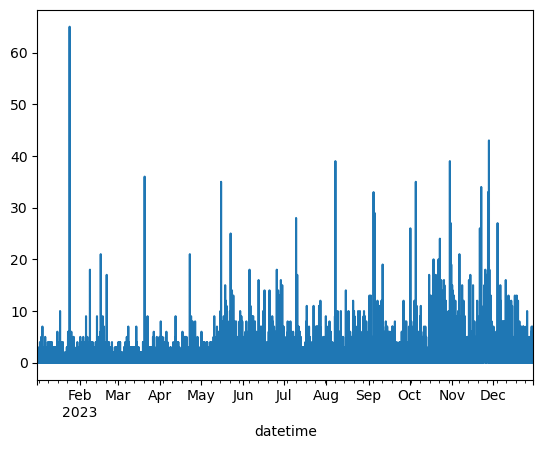

In [782]:
hourly_data['tot_orders'].plot()

In [783]:
# Save dataframe to csv
hourly_data_fe.to_csv('/Users/lucazosso/Desktop/IE_Course/weclomeback/welcomeback_dev/data_science_folder/cleaned/hourly_agg_weather_flavoured_features.csv')
hourly_data.to_csv('/Users/lucazosso/Desktop/IE_Course/weclomeback/welcomeback_dev/data_science_folder/cleaned/hourly_agg_weather_vanilla.csv')

In [784]:
hourly_data_fe.iloc[0, :]

tot_orders                                 1
tot_gross_revenue                      27.72
tot_cogs                                7.65
tot_order_marketplace                      0
tot_order_website                          1
tot_order_b2b                              0
temperature_2m                         6.398
relative_humidity_2m                72.94234
precipitation                            0.0
rain                                     0.0
snowfall                                 0.0
weather_code                             3.0
weather_description                   cloudy
cloud_cover                             87.6
sunshine_duration                        0.0
is_weekend                              True
day_of_week                           Sunday
tot_sessions                              77
product_margin                     27.444026
AOV                                    27.72
cvr                                 0.012987
revenue_per_session                     0.36
lag_weekda

## Analysis

Here the purpose is to work on the new datasets to check some corrolations and distirbutions in order to find some further insights. Now all other more advanced analytics should be done via the RAG system on the user DEMO. Therefore questions like:

- What is my Global Conversion Rate? 
- What is the day of the week I make the most revenue? 
- Do I sell more on rainy days?
ect.

In [785]:
metrics = ['tot_orders', 'tot_sessions', 'tot_gross_revenue', 'product_margin', 'AOV', 'cvr', 'revenue_per_session']
hourly_data[metrics].describe()

,tot_orders,tot_sessions,tot_gross_revenue,product_margin,AOV,cvr,revenue_per_session
count,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000
mean,1.484602,111.217401,209.563681,209.351610,80.038255,0.016963,2.407214
std,2.596207,53.322710,708.822545,708.792609,254.670698,0.037146,9.414780
min,0.000000,18.000000,0.000000,-37.800000,0.000000,0.000000,0.000000
25%,0.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,102.000000,30.000000,29.813333,25.000000,0.007874,0.288591
75%,2.000000,141.000000,158.575000,158.257630,74.765000,0.021398,1.617221
max,65.000000,710.000000,14628.180000,14627.937327,6228.120000,1.333333,282.371786


In [786]:
# check for missing values
hourly_data[metrics].isna().sum()

tot_orders             0
tot_sessions           0
tot_gross_revenue      0
product_margin         0
AOV                    0
cvr                    0
revenue_per_session    0
dtype: int64

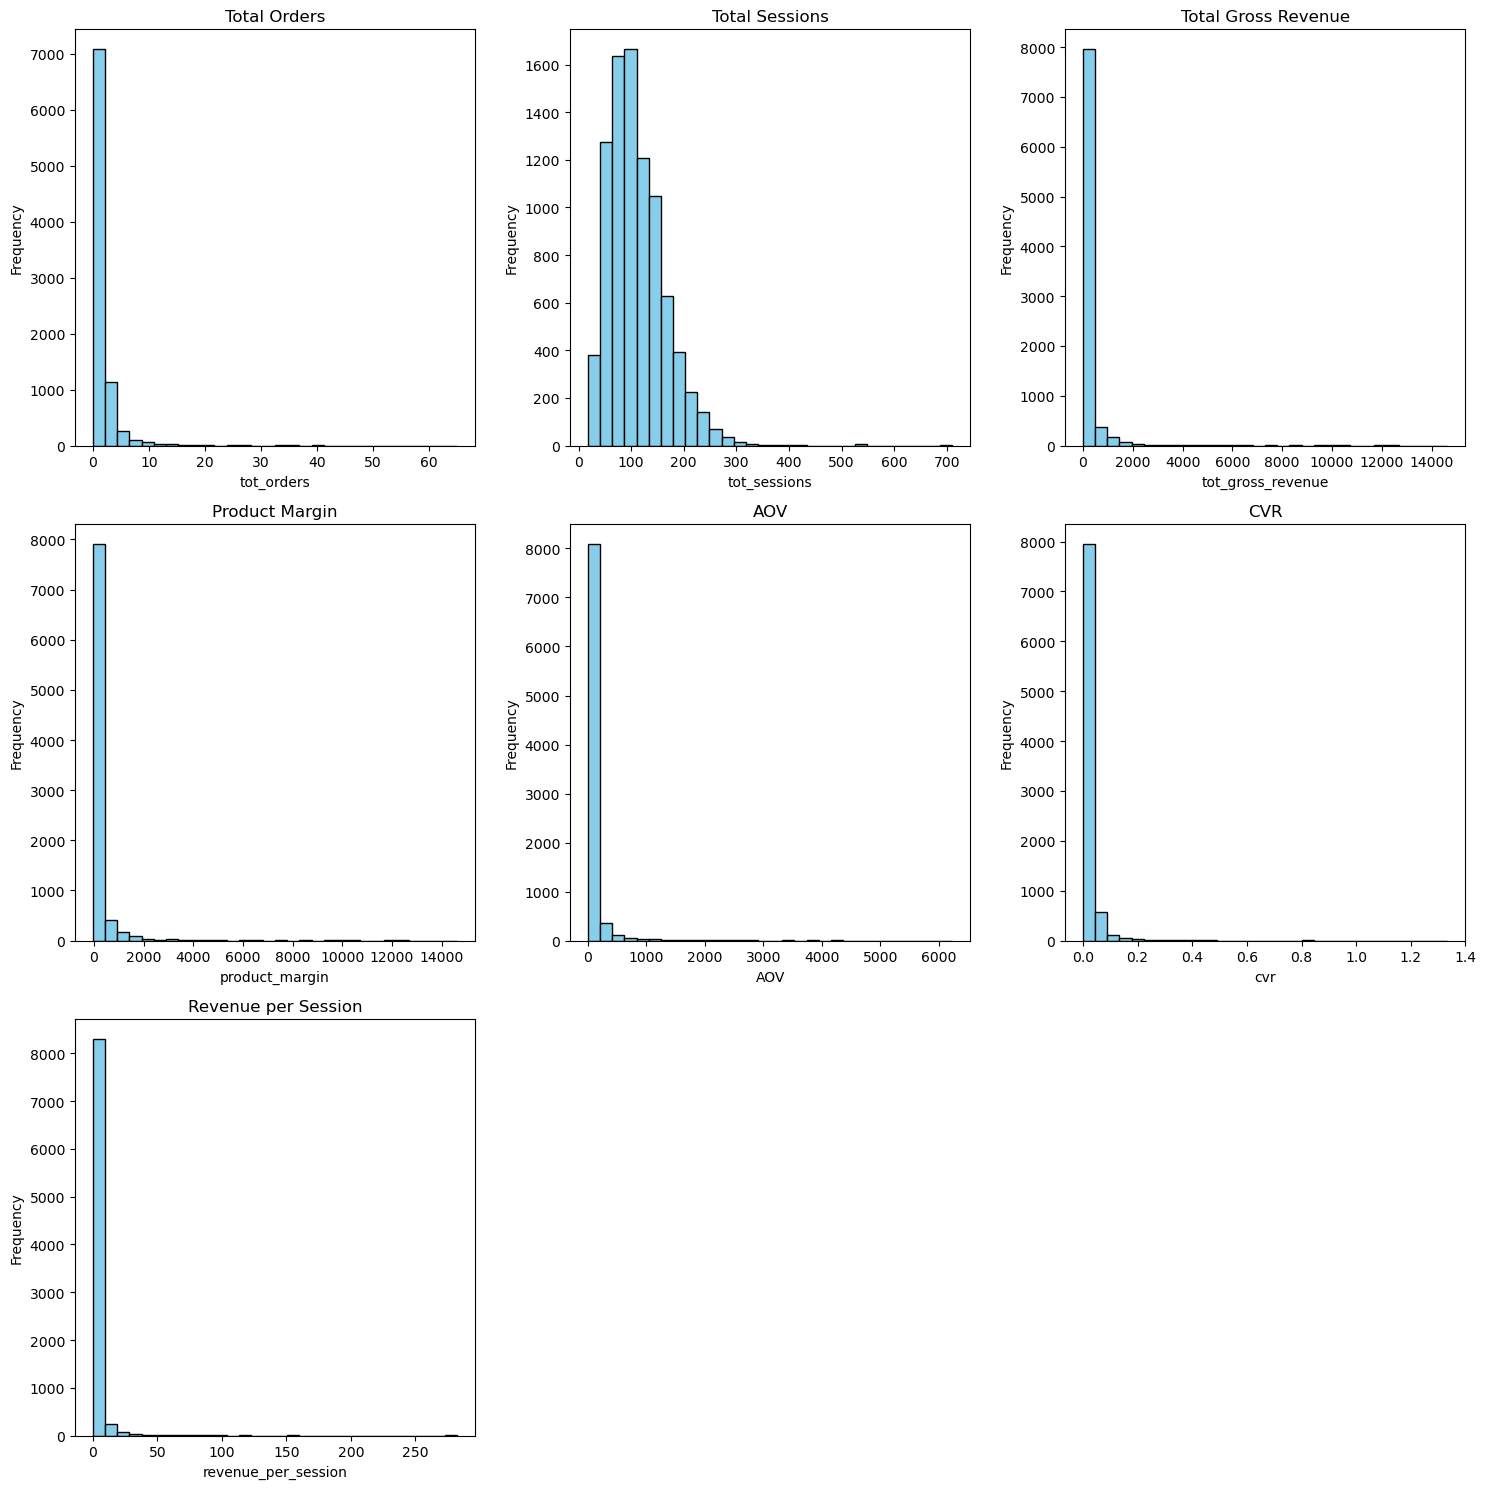

In [787]:
import matplotlib.pyplot as plt

# Create a figure and a grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the array of axes to make indexing easier
axs = axs.flatten()

# Assuming 'hourly_data' is your DataFrame and it contains these columns

# Plot each metric in a separate subplot
metrics = ['tot_orders', 'tot_sessions', 'tot_gross_revenue', 'product_margin', 'AOV', 'cvr', 'revenue_per_session']
titles = ['Total Orders', 'Total Sessions', 'Total Gross Revenue', 'Product Margin', 'AOV', 'CVR', 'Revenue per Session']

for i, metric in enumerate(metrics):
    # Only plot if the metric column exists in the DataFrame
    if metric in hourly_data.columns:
        axs[i].hist(hourly_data[metric].dropna(), bins=30, color='skyblue', edgecolor='black')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(metric)
        axs[i].set_ylabel('Frequency')

# Turn off axes for any unused subplots
for j in range(i+1, 9):
    axs[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


__Some Correlations__

In [788]:
corr = hourly_data[metrics].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
corr.where(~mask).style.background_gradient(cmap='viridis')

,tot_orders,tot_sessions,tot_gross_revenue,product_margin,AOV,cvr,revenue_per_session
tot_orders,nan,nan,nan,nan,nan,nan,nan
tot_sessions,-0.006618,nan,nan,nan,nan,nan,nan
tot_gross_revenue,0.440336,-0.010820,nan,nan,nan,nan,nan
product_margin,0.440219,-0.010813,0.999999,nan,nan,nan,nan
AOV,0.137254,-0.012410,0.767773,0.767764,nan,nan,nan
cvr,0.843089,-0.202981,0.365204,0.365115,0.110954,nan,nan
revenue_per_session,0.392630,-0.115866,0.879122,0.879121,0.686297,0.453435,nan


# Time Series Forecasting

__Methodology__

We are going to perform a time series analysis on our hourly data. We are going to use 3 different approaches:

1. Basic Statistical approach: with a ARIMA/SARIMA model
2. Machine Learning Model: XGBoost
3. Deep Learning: LSTM's

For this exercise, we are going to forecast the total_gross_revenue as a target variable. The choice here was made for the following arguments:

"Total Gross Revenue" is a fundamental metric in ecommerce and business analytics because it directly reflects the total income generated from all sales transactions before any deductions for costs and expenses. It encapsulates the financial outcomes of marketing, sales, pricing strategies, and customer engagement efforts.

Due to its interconnection with other E-Commerce KPI, it would therefore be easy to derive other metrics by of course making some shortcuts.

In [789]:
#vanilla: hourly_data
#flavoured: hourly_data_fe

## Basic Satistical Approach

__Box-Jenkins Methodology__

In [790]:
# Resample initial df to daily
daily_data = df.resample('D').agg({
    'order_id': 'count',  # Count of orders at each datetime
    'tot_gross_revenue': 'sum',  # Total revenue at each datetime
    'tot_cogs': 'sum',  # Total cost of goods sold at each datetime
    'is_order_marketplace': 'sum',  # Number of marketplace orders at each datetime
    'is_order_website': 'sum',  # Number of website orders at each datetime
    'is_order_b2b': 'sum',  # Number of B2B orders at each datetime
    'temperature_2m': 'first',  # Already aggregated into hours
    'relative_humidity_2m': 'first',  # Average relative humidity
    'precipitation': 'first',  # Total precipitation
    'rain': 'first',  # Total rain
    'snowfall': 'first',  # Total snowfall
    'weather_code': 'first',
    'weather_description': 'first',
    'cloud_cover': 'first',  # Average cloud cover
    'sunshine_duration': 'first',  # Total sunshine duration
    'is_weekend': 'first',
    'day_of_week': 'first',
    # You can add more aggregations as required
})
#rename order_id to tot_orders
cols_to_rename = {'order_id':'tot_orders',
                   'is_order_marketplace':'tot_order_marketplace',
                   'is_order_website':'tot_order_website',
                   'is_order_b2b':'tot_order_b2b'
                   }
daily_data.rename(columns=cols_to_rename, inplace=True)

daily_data['is_weekend'] = hourly_data['is_weekend'].astype(bool)

# Add the daily sessions from hourly_sessions
# Convert the index to a DatetimeIndex
hourly_sessions.index = pd.to_datetime(hourly_sessions.index)

# Now you can resample
daily_sessions = hourly_sessions.resample('D').agg({'Sessions': 'sum'})
daily_data['tot_sessions'] = daily_sessions['Sessions']
daily_data.head()



,tot_orders,tot_gross_revenue,tot_cogs,tot_order_marketplace,tot_order_website,tot_order_b2b,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,weather_description,cloud_cover,sunshine_duration,is_weekend,day_of_week,tot_sessions
datetime,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,8,663.57,148.81,0,8,0,6.398,72.942340,0.0,0.0,0.0,3.0,cloudy,87.6,0.0,NaN,Sunday,826
2023-01-02 00:00:00+00:00,27,3832.70,1005.07,0,27,0,7.098,72.297775,0.0,0.0,0.0,3.0,cloudy,100.0,0.0,False,Monday,1584
2023-01-03 00:00:00+00:00,24,6278.11,1923.71,0,24,0,6.798,94.968540,0.8,0.8,0.0,53.0,drizzle,100.0,0.0,False,Tuesday,1703
2023-01-04 00:00:00+00:00,21,5082.55,1262.78,0,21,0,1.298,96.122010,0.0,0.0,0.0,0.0,sunny,10.8,0.0,True,Wednesday,1779
2023-01-05 00:00:00+00:00,26,6286.60,1826.12,0,26,0,6.698,89.218864,0.1,0.1,0.0,51.0,light_drizzle,100.0,0.0,True,Thursday,1523


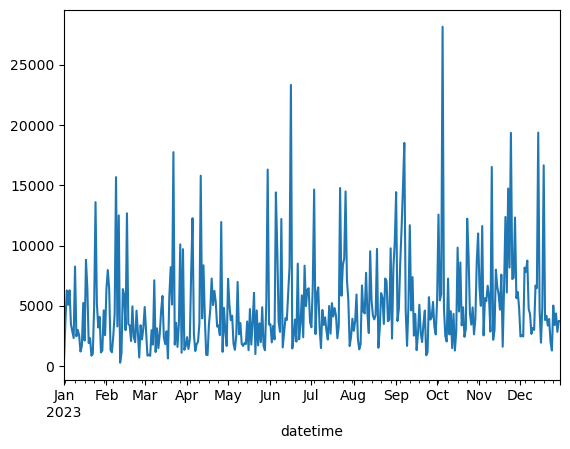

In [791]:
import warnings
warnings.filterwarnings('ignore')
y = daily_data.iloc[:, 1].sort_index() #daily_data
y.plot()
plt.show()

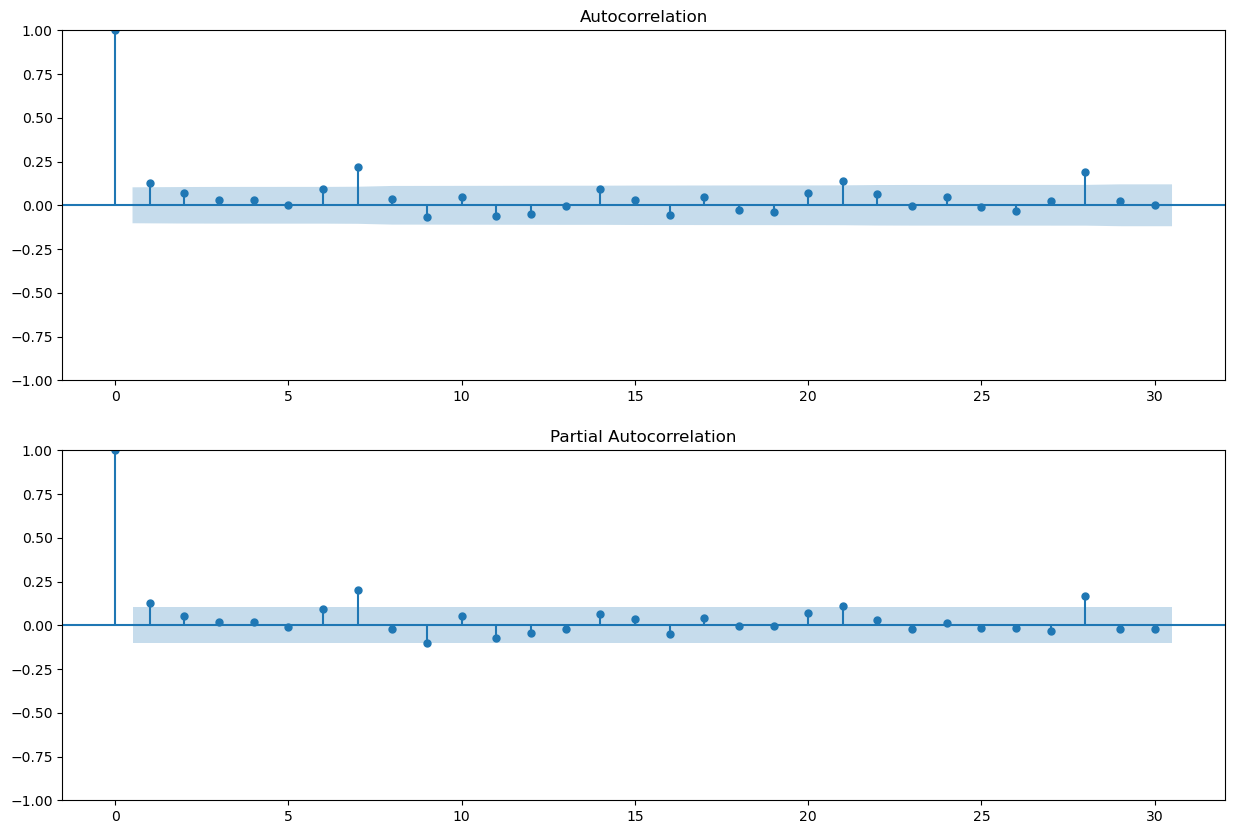

In [792]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
nlags = 30 # play with this parameter

fig, ax = plt.subplots(2,1, figsize = (15,10))
plot_acf(y, lags = nlags,  ax=ax[0])
plot_pacf(y, lags = nlags, method="ols",ax=ax[1])
plt.show()

In [793]:
s = 30 #seasonal parameter | no difference to take
import statsmodels.api as sm
from pmdarima.arima import ndiffs, nsdiffs

print('Regular difference:', ndiffs(y, alpha = 0.05, test = 'adf'))
print('Seasonal difference:', nsdiffs(y, m = s, test = 'ocsb'))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Regular difference: 0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(

In [794]:
box_test = sm.stats.acorr_ljungbox(y, lags=[50])
print("Box test for y:", box_test.iloc[0,0])
print("p-value:", box_test.iloc[0,1])

# Reject the null hypothesis of no autocorrelation if p-value < 0.05

Box test for y: 103.85646532394112
p-value: 1.2090055971017295e-05


Kurtosis 8.689973562737544
Skewness: 2.0551577510395767


(-14526.023286912592, 24583.928506692813)

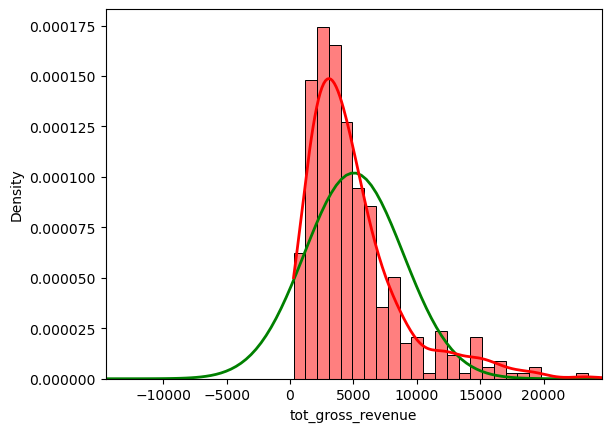

In [795]:
from scipy.stats import skew, kurtosis, shapiro
import scipy.stats as st
import seaborn as sns
# Así coincide con el de R el method = 'moment'
print("Kurtosis",kurtosis(y, fisher = False))
print("Skewness:",skew(y))

mu = np.mean(y)
sigma = np.std(y)
x = np.linspace(mu -5*sigma, mu + 5*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = sns.histplot(y, stat="density", color = "r",
                  kde = True, line_kws={'lw': 2}, bins = 30
                   ) 
ax.set_xlim(mu -5*sigma, mu + 5*sigma)

In [796]:
print("Shapiro test:",shapiro(y)[0])
print("Shapiro p-value:",shapiro(y)[1])

# Reject the null hypothesis of normality if p-value < 0.05

Shapiro test: 0.8117119073867798
Shapiro p-value: 2.761328248154329e-20


So the eda showed us the following.

Our data is normally distributed. But with a lots of variance.
Our data have some autocorrelations in ACF + PACF

Here we will first go for an ARIMA/SARIMA model adn then a GARCH model for the variance

__Start ARIMA/SARIMA Model__

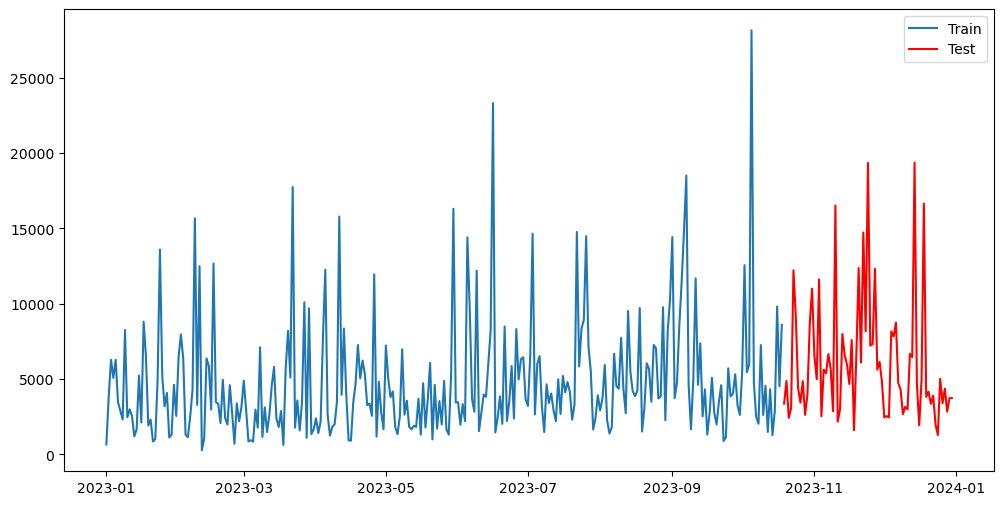

In [797]:
# First train, test split the data
train_size = int(len(y) * 0.8)
train, test = y.iloc[:train_size], y.iloc[train_size:]

plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='red')
plt.legend()
plt.show()

As my variance is high I will do a log transformation to keep it still

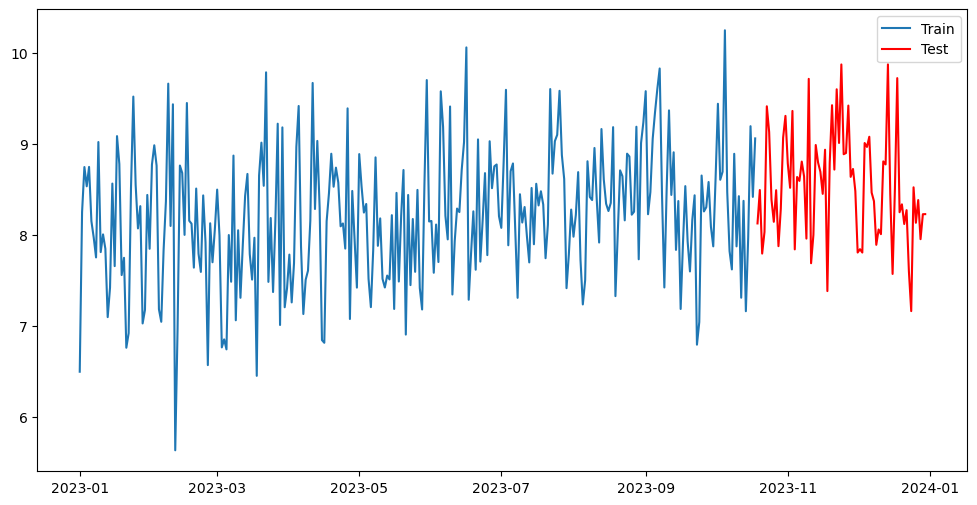

In [798]:
# Log Transform the data
train_log = np.log(train + 1) # Adding 1 to avoid division by zero
test_log = np.log(test + 1)

plt.figure(figsize=(12, 6))
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test', color='red')
plt.legend()
plt.show()

In [799]:
print('Regular difference:', ndiffs(train_log, alpha = 0.05, test = 'adf'))
print('Seasonal difference:', nsdiffs(train_log, m = s, test = 'ocsb'))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Regular difference: 0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(

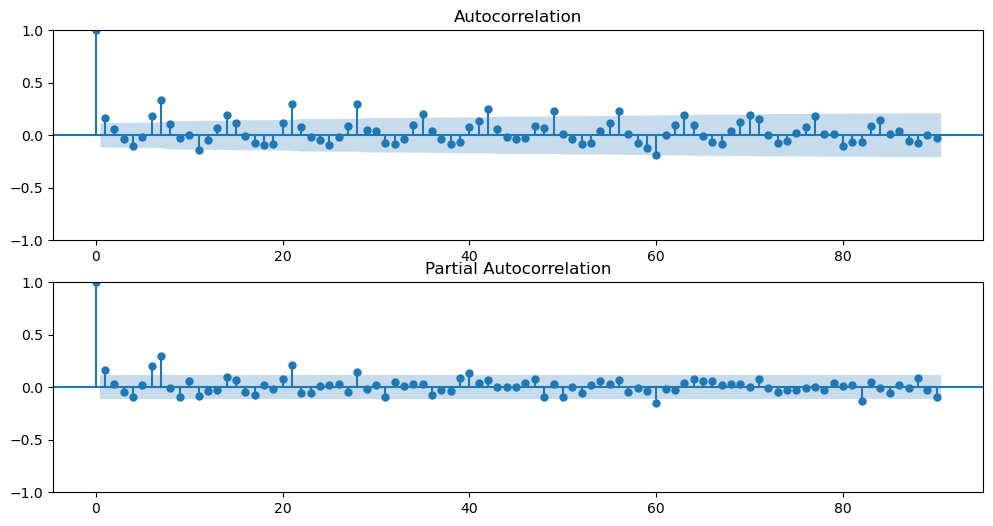

In [800]:
# Plot ACF/PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(train_log, ax=plt.gca(), lags=90)
plt.subplot(212)
plot_pacf(train_log, ax=plt.gca(), lags=90)
plt.show()

In [801]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example SARIMA order and seasonal order, adjust based on your data analysis
#p=AR, d=differencing, q=MA
p, d, q = 1, 0, 1       # For dail_data: 1,0,1
P, D, Q, S = 1, 0, 1, 7  # For dail_data: 1,0,1,7

# Fit the SARIMA model
model = SARIMAX(train_log, order=(p, d, q), seasonal_order=(P, D, Q, S))
model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42830D+00    |proj g|=  2.97060D+00

At iterate    5    f=  1.09649D+00    |proj g|=  6.33308D-02

At iterate   10    f=  1.04591D+00    |proj g|=  3.93846D-02

At iterate   15    f=  1.00815D+00    |proj g|=  4.86040D-02

At iterate   20    f=  9.95576D-01    |proj g|=  2.94793D-03

At iterate   25    f=  9.94472D-01    |proj g|=  8.23783D-04

At iterate   30    f=  9.94218D-01    |proj g|=  4.70771D-04


 This problem is unconstrained.



At iterate   35    f=  9.94133D-01    |proj g|=  2.84797D-04

At iterate   40    f=  9.94031D-01    |proj g|=  5.48374D-03

At iterate   45    f=  9.94003D-01    |proj g|=  2.06978D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     73      1     0     0   4.032D-04   9.940D-01
  F =  0.99399096403115794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) i

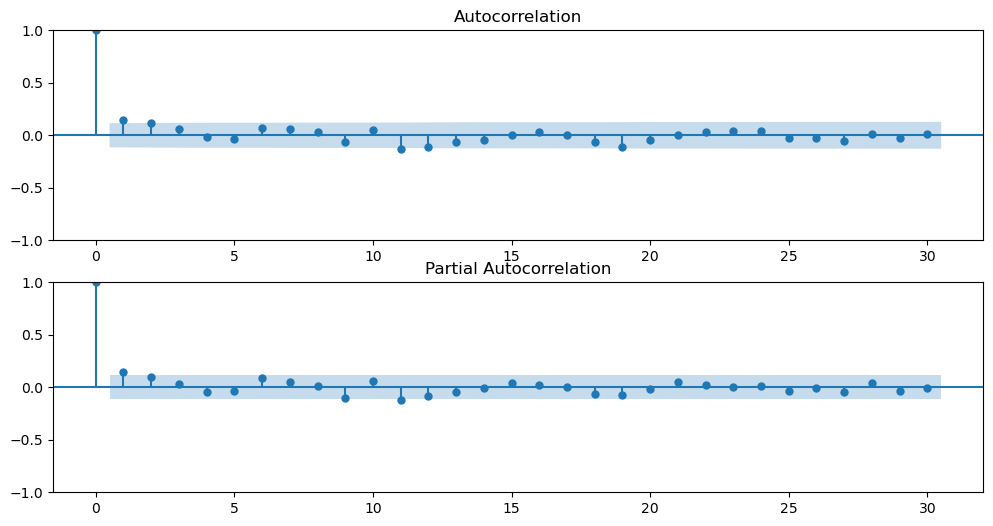

Shapiro-Wilk Test: ShapiroResult(statistic=0.8755534291267395, pvalue=1.2761716867721457e-14)
Box-Ljung Test:       lb_stat  lb_pvalue
50  52.889383   0.363181


In [802]:
# Check residuals
residuals = model_fit.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, ax=plt.gca(), lags=30)
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca(), lags=30)
plt.show()

# Perform Shapiro-Wilk test for normality
from scipy.stats import shapiro

print('Shapiro-Wilk Test:', shapiro(residuals))

# Perform Box-Ljung test for autocorrelation on residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

print('Box-Ljung Test:', acorr_ljungbox(residuals, lags=[50]))

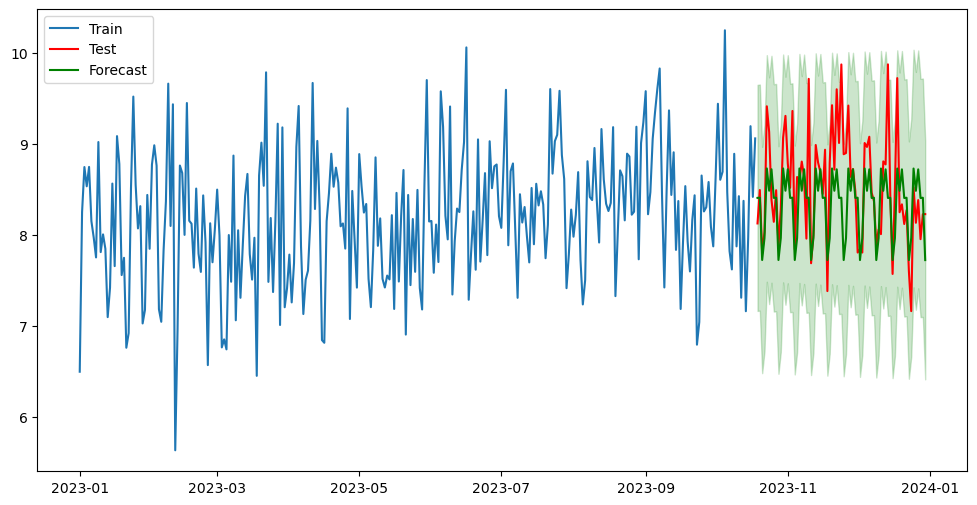

MSE: 0.27314792563839224
MAE: 0.38704396972119653
RMSE: 0.5226355571891299
MAPE: 4.400450887444928


In [803]:
# Forecasting
forecast = model_fit.get_forecast(steps=test_log.shape[0])
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train_log.index, train_log, label='Train')
plt.plot(test_log.index, test_log, label='Test', color='red')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.show()

# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mse = mean_squared_error(test_log, forecast_mean)
mae = mean_absolute_error(test_log, forecast_mean)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_log, forecast_mean)

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape*100)


__Detransforming the log process and check forecasting__

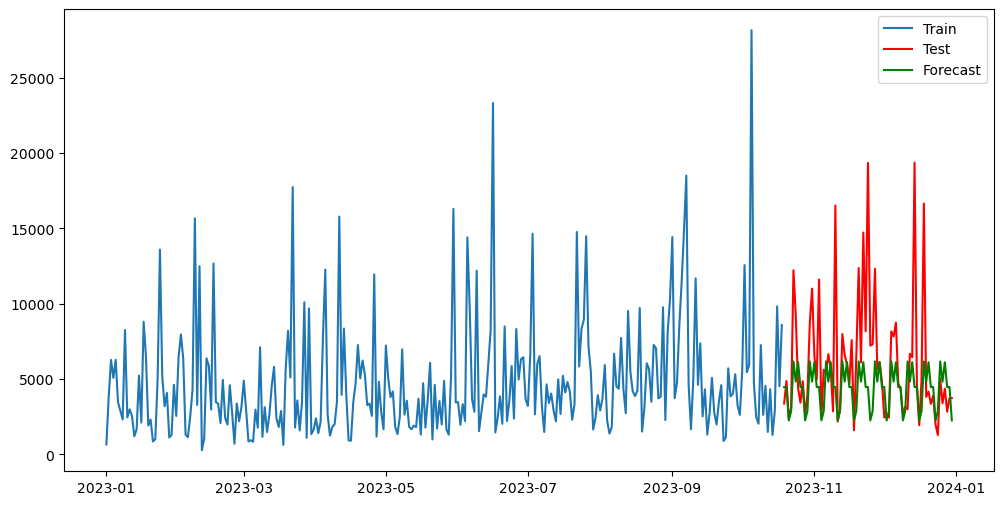

In [804]:
# Undo the log transformation and plot the forecasting results

# Forecasting
arima_forecast = model_fit.get_forecast(steps=test_log.shape[0])
arima_forecast_mean_log = arima_forecast.predicted_mean

# Undo the log transformation
arima_forecast_mean = np.exp(arima_forecast_mean_log) - 1

# Plot the combined forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='red')
plt.plot(test.index, arima_forecast_mean, label='Forecast', color='green')
plt.legend()
plt.show()


In [805]:
mse = mean_squared_error(test, arima_forecast_mean)
mae = mean_absolute_error(test, arima_forecast_mean)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, arima_forecast_mean)

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape*100)

MSE: 16087620.777364489
MAE: 2407.226198567144
RMSE: 4010.9376431658084
MAPE: 32.61889377702028


__Conclusion__

As the hypothesis Box test told me that my residuals where not white noise, I should have added a Garch model for my residuals. Either way this first method was just to show that a statistical model is not the best approach as variance is very hard to forecast.

## Prophet

## Machine Learning

__XGBoost Model as Time serie Regressor__

So here the idea is the following, we will use an XGBoost Regressor in order to forcast the daily gross turnover.

The way we are going to this is by:

→ First slice your time-series data into (features, target) pairs.

→ Set a window length (aka feature vector size) and step size (to control granularity) and iterate

In [806]:
# Check if hourly_data_fe index has no gaps or duplicated
hourly_data_fe.index.is_unique
hourly_data_fe.index.is_monotonic_increasing


True

In [807]:
hourly_data_fe.dtypes

tot_orders                           int64
tot_gross_revenue                  float64
tot_cogs                           float64
tot_order_marketplace                int64
tot_order_website                    int64
tot_order_b2b                        int64
temperature_2m                     float64
relative_humidity_2m               float64
precipitation                      float64
rain                               float64
snowfall                           float64
weather_code                       float64
weather_description                 object
cloud_cover                        float64
sunshine_duration                  float64
is_weekend                            bool
day_of_week                         object
tot_sessions                         int64
product_margin                     float64
AOV                                float64
cvr                                float64
revenue_per_session                float64
lag_weekday_tot_orders             float64
lag_weekday

PreProcessing
We are going to scale the numeric features + one hot encode the categorical

In [808]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb

# Example DataFrame setup (assuming you have a datetime index)
# hourly_data_fe = pd.DataFrame(...)  # Your actual DataFrame

# Drop the 'weather_code' column before preprocessing
hourly_data_fe = hourly_data_fe.drop(columns=['weather_description', 'lag_1_revenue_per_session']) # Remove lag_1_revenue_per_session as it is highly correlated with revenue_per_session

# Ensure the datetime index is converted to features
hourly_data_fe['year'] = hourly_data_fe.index.year.astype(str)
hourly_data_fe['month'] = hourly_data_fe.index.month.astype(str)
hourly_data_fe['day'] = hourly_data_fe.index.day.astype(str)
hourly_data_fe['hour'] = hourly_data_fe.index.hour.astype(str)
#hourly_data_fe['day_of_week'] = hourly_data_fe.index.dayofweek

# Reset the index to make datetime features part of the DataFrame
hourly_data_fe = hourly_data_fe.reset_index(drop=True)
hourly_data_fe = hourly_data_fe.fillna(0)
# Convert day_of_week to string to ensure uniform type for OneHotEncoder
hourly_data_fe['day_of_week'] = hourly_data_fe['day_of_week'].astype(str)
hourly_data_fe['is_weekend'] = hourly_data_fe['is_weekend'].astype(str)
hourly_data_fe['weather_code'] = hourly_data_fe['weather_code'].astype(str)

hourly_data_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8735 entries, 0 to 8734
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   tot_orders                       8735 non-null   int64  
 1   tot_gross_revenue                8735 non-null   float64
 2   tot_cogs                         8735 non-null   float64
 3   tot_order_marketplace            8735 non-null   int64  
 4   tot_order_website                8735 non-null   int64  
 5   tot_order_b2b                    8735 non-null   int64  
 6   temperature_2m                   8735 non-null   float64
 7   relative_humidity_2m             8735 non-null   float64
 8   precipitation                    8735 non-null   float64
 9   rain                             8735 non-null   float64
 10  snowfall                         8735 non-null   float64
 11  weather_code                     8735 non-null   object 
 12  cloud_cover         

__XGBoost Baseline__

In [809]:
seed = 42


# Define the columns to be scaled
numeric_cols = hourly_data_fe.drop(columns=['lag_1_tot_gross_revenue']).select_dtypes(include=['float64', 'int64']).columns

# Define the columns to be encoded
categorical_cols = hourly_data_fe.select_dtypes(include=['object']).columns

# Separate the target variable
target_variable = 'lag_1_tot_gross_revenue'
X = hourly_data_fe.drop(columns=[target_variable])
y = hourly_data_fe[target_variable]

# Define the preprocessing pipeline for features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Fit and transform the feature preprocessor
X_preprocessed = preprocessor.fit_transform(X)

# Convert preprocessed features to DataFrame to keep column names
numeric_features = numeric_cols.tolist()
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()
all_features = numeric_features + categorical_features
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_features)

# Define the time series cross-validator
tscv = TimeSeriesSplit(n_splits=20)

# Initialize lists to store evaluation metrics
train_mae_scores = []
train_mse_scores = []
train_rmse_scores = []
train_mape_scores = []

test_mae_scores = []
test_mse_scores = []
test_rmse_scores = []
test_mape_scores = []

# Perform time series cross-validation
for train_index, test_index in tscv.split(X_preprocessed_df):
    X_train, X_test = X_preprocessed_df.iloc[train_index], X_preprocessed_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Define the model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed,verbose=2,reg_lambda=1,reg_alpha=1,learning_rate=0.1,max_depth=3,n_estimators=200)
    
    # according to GridSearch: Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}
    
    # Train the model on the processed training data
    model.fit(X_train, y_train)
    
    # Evaluate the model on the processed training data
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    
    # Append training metrics to the lists
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)
    train_rmse_scores.append(train_rmse)
    train_mape_scores.append(train_mape)
    
    # Evaluate the model on the processed testing data
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    
    # Append testing metrics to the lists
    test_mae_scores.append(test_mae)
    test_mse_scores.append(test_mse)
    test_rmse_scores.append(test_rmse)
    test_mape_scores.append(test_mape)

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Train MAE': train_mae_scores,
    'Test MAE': test_mae_scores,
    'Train MSE': train_mse_scores,
    'Test MSE': test_mse_scores,
    'Train RMSE': train_rmse_scores,
    'Test RMSE': test_rmse_scores,
    'Train MAPE': train_mape_scores,
    'Test MAPE': test_mape_scores
})

# Add average metrics to the DataFrame
#metrics_df.loc['Average'] = metrics_df.mean()

metrics_df

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAPE,Test MAPE
0,0.006053,50.947338,0.000071,98553.545645,0.008422,313.932390,1.099120e+13,1.085587e+15
1,0.042213,74.220971,0.003555,348770.242705,0.059620,590.567729,5.761982e+13,1.624394e+15
2,0.091007,15.173016,0.018804,11883.735262,0.137128,109.012546,1.143958e+14,8.107001e+14
3,0.150164,62.043441,0.053513,280012.335284,0.231330,529.161918,1.488010e+14,1.025679e+15
4,0.197096,32.629701,0.088560,59121.231600,0.297590,243.148579,1.966028e+14,1.374919e+15
5,0.262942,58.411924,0.179954,322619.878126,0.424210,567.996372,2.232463e+14,1.015548e+15
6,0.331276,29.897367,0.286443,123250.525748,0.535204,351.070542,2.442834e+14,1.082212e+15
7,0.303024,38.667141,0.252537,94292.317082,0.502531,307.070541,1.820616e+14,7.493705e+14
8,0.439779,31.085362,0.600077,96538.180128,0.774646,310.705938,2.483117e+14,1.149202e+15
9,0.617215,32.324109,1.118021,47023.772295,1.057365,216.849654,3.543222e+14,9.084977e+14


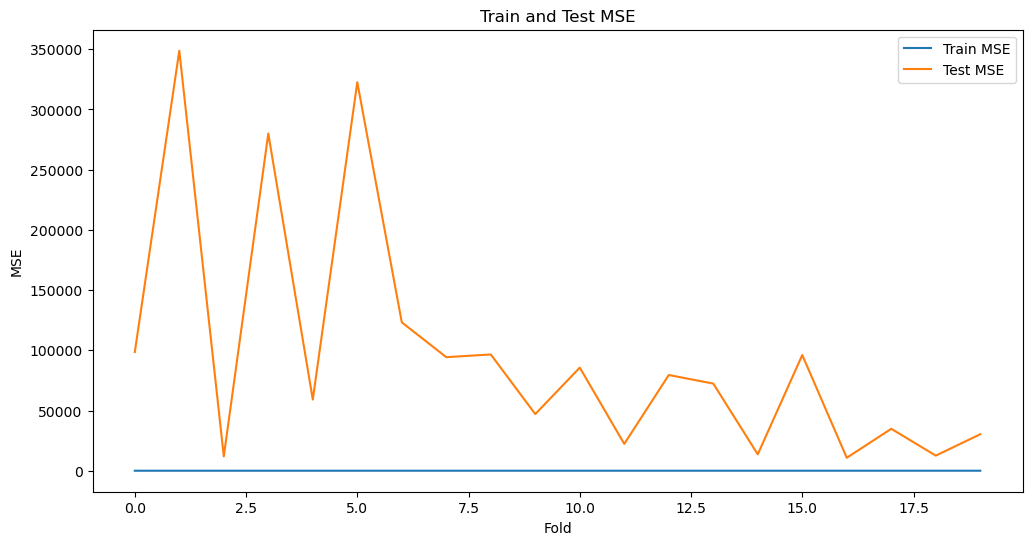

In [810]:
# Plot Error Loss on train and test only for MSE as it is the loss funciton of the XGBoost
plt.figure(figsize=(12, 6))
# exclude averafe row

plt.plot(metrics_df['Train MSE'], label='Train MSE')
plt.plot(metrics_df['Test MSE'], label='Test MSE')
plt.title('Train and Test MSE')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()
plt.show()

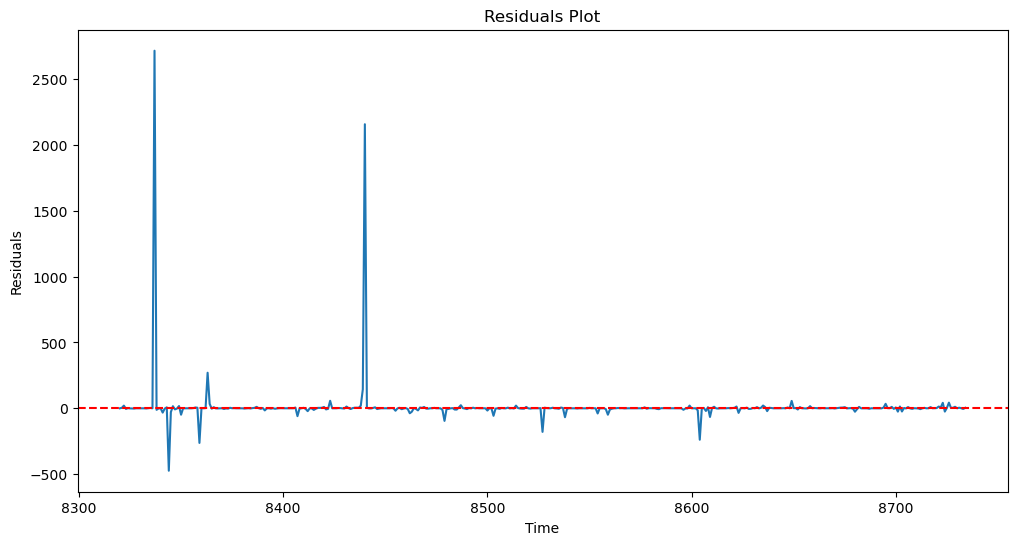

In [811]:
# Plot the residuals
residuals = y_test - y_test_pred

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

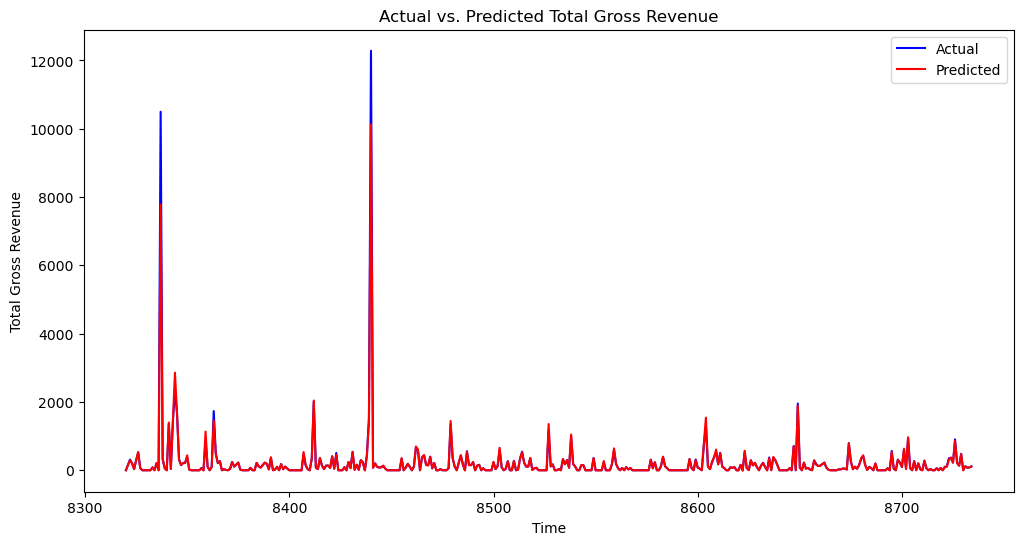

In [812]:
# Plot the target variable and predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Total Gross Revenue')
plt.title('Actual vs. Predicted Total Gross Revenue')
plt.legend()
plt.show()

In [813]:
# Create a dataframe with the feature importances
importances = model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})

# Sort the features by importance
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False).style.background_gradient(cmap='viridis')

feature_importances_df





,Feature,Importance
24,lag_1_AOV,0.340570
23,lag_1_tot_orders,0.240419
91,day_22,0.140638
38,lag_720_AOV,0.038549
18,lag_weekday_tot_orders,0.035395
27,lag_24_tot_gross_revenue,0.021248
16,cvr,0.018961
20,lag_weekday_AOV,0.016916
1,tot_gross_revenue,0.015961
12,sunshine_duration,0.011310


__XGBoost for time Series Conclusion__

XGBoost is too much performant for this demo data. I have to many features which make it to prone to overfitting. I have tried to reduce it with some regularization. If I have more time I will come back to reduce dimensionality. This also makes me think that deep learning here will also produce the same case of overfitting.

### Fine Tuning The model Just for fun

In [815]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# import xgboost as xgb
# from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# import numpy as np
# import matplotlib.pyplot as plt


# # Define the time series cross-validator
# tscv = TimeSeriesSplit(n_splits=20)

# # Define the model
# model = xgb.XGBRegressor()

# # Define the hyperparameters grid
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'reg_alpha': [0, 0.1, 1],  # L1 regularization
#     'reg_lambda': [1, 10]      # L2 regularization
# }

# # Define the GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# # Perform GridSearchCV
# grid_search.fit(X_preprocessed_df, y)

# # Best model from GridSearchCV
# best_model = grid_search.best_estimator_

# # Initialize lists to store evaluation metrics
# train_mae_scores = []
# train_mse_scores = []
# train_rmse_scores = []
# train_mape_scores = []

# test_mae_scores = []
# test_mse_scores = []
# test_rmse_scores = []
# test_mape_scores = []

# # Perform time series cross-validation with the best model
# for train_index, test_index in tscv.split(X_preprocessed_df):
#     X_train, X_test = X_preprocessed_df.iloc[train_index], X_preprocessed_df.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Train the model on the processed training data
#     best_model.fit(X_train, y_train)
    
#     # Evaluate the model on the processed training data
#     y_train_pred = best_model.predict(X_train)
#     train_mae = mean_absolute_error(y_train, y_train_pred)
#     train_mse = mean_squared_error(y_train, y_train_pred)
#     train_rmse = np.sqrt(train_mse)
#     train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    
#     # Append training metrics to the lists
#     train_mae_scores.append(train_mae)
#     train_mse_scores.append(train_mse)
#     train_rmse_scores.append(train_rmse)
#     train_mape_scores.append(train_mape)
    
#     # Evaluate the model on the processed testing data
#     y_test_pred = best_model.predict(X_test)
#     test_mae = mean_absolute_error(y_test, y_test_pred)
#     test_mse = mean_squared_error(y_test, y_test_pred)
#     test_rmse = np.sqrt(test_mse)
#     test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    
#     # Append testing metrics to the lists
#     test_mae_scores.append(test_mae)
#     test_mse_scores.append(test_mse)
#     test_rmse_scores.append(test_rmse)
#     test_mape_scores.append(test_mape)

# # Create a DataFrame to store the metrics
# metrics_df = pd.DataFrame({
#     'Train MAE': train_mae_scores,
#     'Test MAE': test_mae_scores,
#     'Train MSE': train_mse_scores,
#     'Test MSE': test_mse_scores,
#     'Train RMSE': train_rmse_scores,
#     'Test RMSE': test_rmse_scores,
#     'Train MAPE': train_mape_scores,
#     'Test MAPE': test_mape_scores
# })

# # Add average metrics to the DataFrame
# metrics_df.loc['Average'] = metrics_df.mean()

# print(metrics_df)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [817]:
metrics_df

,Train MAE,Test MAE,Train MSE,Test MSE,Train RMSE,Test RMSE,Train MAPE,Test MAPE
0,3.905408,48.850059,46.315224,87955.965921,6.805529,296.573711,2.005148e+15,1.087380e+16
1,7.018645,71.788287,168.978364,266069.397184,12.999168,515.819152,2.793910e+15,5.658077e+15
2,7.765372,17.217397,251.180446,7086.138537,15.848673,84.179205,2.918249e+15,3.627406e+15
3,6.285760,50.454165,197.774988,137670.153233,14.063250,371.039288,2.072352e+15,3.732649e+15
4,6.225188,33.976117,234.721967,54812.540400,15.320639,234.120782,1.203748e+15,3.437213e+15
5,6.332730,36.358101,224.836565,76214.007330,14.994551,276.068845,1.494332e+15,2.401751e+15
6,9.131167,22.694934,442.753973,14813.302500,21.041720,121.709911,1.864473e+15,2.870136e+15
7,8.202189,38.692445,355.081331,94819.965679,18.843602,307.928507,1.660076e+15,1.693353e+15
8,10.256876,42.207246,521.421111,76956.589579,22.834647,277.410507,1.752256e+15,1.484674e+15
9,14.231850,47.462293,920.939235,61178.398876,30.346981,247.342675,2.617779e+15,4.898939e+15


In [818]:
# Print the best hyperparameters
#print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}


## Facebook Prophet

In [854]:
# import Facebook Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation


seed = 42

# Use the daily data
data = daily_data.reset_index()
# remove timezone information
data['datetime'] = data['datetime'].dt.tz_localize(None)
data_revenue = data.rename(columns={'datetime': 'ds', 'tot_gross_revenue': 'y'})
data_revenue = data_revenue[['ds', 'y']]

# data_orders = data.rename(columns={'datetime': 'ds', 'tot_orders': 'y'})
# data_orders = data_orders[['ds', 'y']]

# Slit the data into train and test 
train_size = int(len(data_revenue) * 0.8)
train_revenue, test_revenue = data_revenue.iloc[:train_size], data_revenue.iloc[train_size:]

# Baseline Model
base_model = Prophet()
base_model.add_country_holidays(country_name='CH')  # Prophet includes CH holidays + BlackFriday and CyberMonday
base_model.fit(train_revenue)

# Create a dataframe for future dates including the test period
future_dates = base_model.make_future_dataframe(periods=len(test_revenue))
forecast = base_model.predict(future_dates)

# Plot forecast
plot_plotly(base_model, forecast).show()

# Align the predictions with the test set
forecast_test = forecast.set_index('ds').loc[test_revenue['ds']]
residuals = test_revenue['y'] - forecast_test['yhat']

# Compute performance metrics
mae = mean_absolute_error(test_revenue['y'], forecast_test['yhat'])
mse = mean_squared_error(test_revenue['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_revenue['y'], forecast_test['yhat'])

performance_metrics = pd.DataFrame({
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAPE': [mape * 100]
})

performance_metrics

14:40:28 - cmdstanpy - INFO - Chain [1] start processing
14:40:29 - cmdstanpy - INFO - Chain [1] done processing


,MAE,MSE,RMSE,MAPE
0,2668.411742,1.354510e+07,3680.367134,51.924587


In [855]:
# Python
import itertools

# Search Grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [1, 5, 10, 15],  # default 10
    'seasonality_mode': ['additive', 'multiplicative'],  # default 'additive'
    'changepoint_range': [0.6, 0.7, 0.8, 0.9]  # default 0.8
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use the training data to evaluate all parameters
for params in all_params:
    # Initialize and fit the model with given params
    model = Prophet(**params)
    model.add_country_holidays(country_name='CH')  # Adding holidays
    model.fit(train_revenue)
    
    # Create a dataframe for future dates including the test period
    future_dates = model.make_future_dataframe(periods=len(test_revenue))
    forecast = model.predict(future_dates)
    
    # Align the predictions with the test set
    forecast_test = forecast.set_index('ds').loc[test_revenue['ds']]
    
    # Compute RMSE for the current set of parameters
    rmse = np.sqrt(mean_squared_error(test_revenue['y'], forecast_test['yhat']))
    rmses.append(rmse)

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print("Best Parameters:", best_params)

# Fit the model with the best parameters
best_model = Prophet(**best_params)
best_model.add_country_holidays(country_name='CH')
best_model.fit(train_revenue)

# Create a dataframe for future dates including the test period
future_dates = best_model.make_future_dataframe(periods=len(test_revenue))
forecast = best_model.predict(future_dates)

# Plot forecast
plot_plotly(best_model, forecast).show()

# Compute performance metrics
forecast_test = forecast.set_index('ds').loc[test_revenue['ds']]
residuals = test_revenue['y'] - forecast_test['yhat']

mae = mean_absolute_error(test_revenue['y'], forecast_test['yhat'])
mse = mean_squared_error(test_revenue['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_revenue['y'], forecast_test['yhat'])

performance_metrics = pd.DataFrame({
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAPE': [mape * 100]
})

performance_metrics

14:45:24 - cmdstanpy - INFO - Chain [1] start processing
14:45:24 - cmdstanpy - INFO - Chain [1] done processing
14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing
14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing
14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing
14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing
14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing
14:45:25 - cmdstanpy - INFO - Chain [1] start processing
14:45:25 - cmdstanpy - INFO - Chain [1] done processing
14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1] done processing
14:45:26 - cmdstanpy - INFO - Chain [1] start processing
14:45:26 - cmdstanpy - INFO - Chain [1]

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                     1   
1                      0.001                     0.01                     1   
2                      0.001                     0.01                     1   
3                      0.001                     0.01                     1   
4                      0.001                     0.01                     1   
..                       ...                      ...                   ...   
635                    0.500                    10.00                    15   
636                    0.500                    10.00                    15   
637                    0.500                    10.00                    15   
638                    0.500                    10.00                    15   
639                    0.500                    10.00                    15   

    seasonality_mode  changepoint_range         rms

,MAE,MSE,RMSE,MAPE
0,2634.211858,1.337560e+07,3657.266116,49.793278


# Time Series Forecasting Conclusion

The time series forecasting was a great exercise however need more time to really put these into production for our demo. It made us thought about using such algorithms/methods for short time series forecasting +7days, +14days, +30days, +90days. Not more as the more you stretch the forecasting horizon the more error prone you are.

# RFM Model

As the time series forecasting didn't give us much interesting output for our demo usecase. We will create here a simple RFM model in order to create more insights for our Demo. In order for the RAG system to answer questions such as:

* Who are the top customers?
* Which customers may leave?
* Who could be valuable customers?
* Which customers can be kept?
* Who is most likely to respond to campaigns?

__RFM Segmentation__
Champions: Recent, frequent customers with high spending.

Loyal Customers: Frequent customers who spend good money.

Potential Loyalist: Recent customers with a potential to become loyal.

New Customers: Recent customers who have just made their first purchase.

At Risk: Customers who used to purchase frequently but haven't recently.

Hibernating: Customers who haven't purchased for a long time, and don’t spend much.

Can’t Lose Them: Customers who used to spend big money and purchase often but haven’t returned for a while.

_NB_:

Recency (R): This measures how recently a customer made a purchase. A lower recency value is better, as it means the customer has purchased more recently.

Frequency (F): This measures how often a customer makes a purchase within a given time period. A higher frequency value is better, as it means the customer makes purchases more often.

Monetary Value (M): This measures how much money a customer has spent over a given time period. A higher monetary value is better, as it means the customer spends more.


In [893]:
path_cust = '/Users/lucazosso/Desktop/IE_Course/weclomeback/welcomeback_dev/data_science_folder/cleaned/hourly_orders_vanilla.csv'
data_w_cust = pd.read_csv(path_cust)   
data_w_cust.head()

,date,order_id,postcode,day_of_week,tot_orders,tot_gross_revenue,tot_cogs,tot_orders_marketplace,tot_orders_int,tot_orders_b2b,tot_gross_revenue_mrktpl,tot_gross_revenue_int,tot_gross_revenue_b2b,AOV,lag_weekday_tot_orders,lag_weekday_tot_gross_revenue,lag_weekday_AOV,customer_id
0,2023-04-24 08:28:21,138981,6928,Monday,1,49.00,9.30,1,0,0,49.00,0.0,0.0,49.00,1.0,16.72,16.72,14368
1,2023-07-10 21:20:50,230651,1468,Monday,1,152.28,95.58,1,0,0,152.28,0.0,0.0,152.28,1.0,67.92,67.92,10483
2,2023-10-21 11:20:47,341493,6900,Saturday,1,29.90,6.00,1,0,0,29.90,0.0,0.0,29.90,1.0,28.90,28.90,4086
3,2023-05-25 20:58:41,157514,8047,Thursday,1,53.70,15.00,1,0,0,53.70,0.0,0.0,53.70,1.0,357.85,357.85,3588
4,2023-10-24 06:52:15,342566,6618,Tuesday,1,29.90,7.20,1,0,0,29.90,0.0,0.0,29.90,1.0,32.90,32.90,15702


In [894]:
data_w_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12968 entries, 0 to 12967
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           12968 non-null  object 
 1   order_id                       12968 non-null  int64  
 2   postcode                       12961 non-null  object 
 3   day_of_week                    12968 non-null  object 
 4   tot_orders                     12968 non-null  int64  
 5   tot_gross_revenue              12968 non-null  float64
 6   tot_cogs                       12901 non-null  float64
 7   tot_orders_marketplace         12968 non-null  int64  
 8   tot_orders_int                 12968 non-null  int64  
 9   tot_orders_b2b                 12968 non-null  int64  
 10  tot_gross_revenue_mrktpl       12968 non-null  float64
 11  tot_gross_revenue_int          12968 non-null  float64
 12  tot_gross_revenue_b2b          12968 non-null 

In [895]:
# Rename tot_orders columns tta should be a boolean
renamed_cols = {'tot_orders_marketplace':'is_order_marketplace',
                'tot_orders_int': 'is_order_website',
                'tot_orders_b2b': 'is_order_b2b',
                }
data_w_cust.rename(columns=renamed_cols, inplace=True)
# Delete some columns that were badly computed in the SQL statement
cols_to_drop = ['tot_orders', 'tot_gross_revenue_mrktpl', 'tot_gross_revenue_int', 
                'tot_gross_revenue_b2b', 'AOV','lag_weekday_tot_orders','lag_weekday_tot_gross_revenue',
                'lag_weekday_AOV']


data_w_cust.drop(columns=cols_to_drop, inplace=True)

# Create is_weekend column
data_w_cust['is_weekend'] = data_w_cust['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

data_w_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12968 entries, 0 to 12967
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  12968 non-null  object 
 1   order_id              12968 non-null  int64  
 2   postcode              12961 non-null  object 
 3   day_of_week           12968 non-null  object 
 4   tot_gross_revenue     12968 non-null  float64
 5   tot_cogs              12901 non-null  float64
 6   is_order_marketplace  12968 non-null  int64  
 7   is_order_website      12968 non-null  int64  
 8   is_order_b2b          12968 non-null  int64  
 9   customer_id           12968 non-null  int64  
 10  is_weekend            12968 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 1.1+ MB



Champions: Highest recency, frequency, and monetary scores.

Loyal Customers: High recency, frequency, and monetary scores but not as high as Champions.

Potential Loyalist: High recency and moderate frequency.

New Customers: Very recent purchases with low frequency.

At Risk: Low recency and high frequency.

Hibernating: Low recency and low monetary value.

Can’t Lose Them: Low recency but high frequency and monetary value.

High Spending Infrequent Customers: Moderate recency and low frequency but high monetary value.

Frequent Low Spenders: Moderate recency and frequency but low monetary value.

Recent Low Spenders: High recency but low frequency and monetary value.

Others: Customers who do not fit into any of the above segments.

In [899]:
class RFM:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.reference_date = None
        self.rfm_df = None

    def preprocess(self):
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df['month'] = self.df['date'].dt.to_period('M')
        self.reference_date = self.df['date'].max()

    def calculate_rfm(self):
        # Recency calculation
        recency_df = self.df.groupby('customer_id').agg({
            'date': lambda x: (self.reference_date - x.max()).days
        }).reset_index()
        recency_df.columns = ['customer_id', 'recency']

        # Monthly frequency calculation
        monthly_orders = self.df.groupby(['customer_id', 'month']).agg({
            'order_id': 'nunique'
        }).reset_index()
        frequency_df = monthly_orders.groupby('customer_id').agg({
            'order_id': 'mean'
        }).reset_index()
        frequency_df.columns = ['customer_id', 'frequency']

        # Monetary calculation
        monetary_df = self.df.groupby('customer_id').agg({
            'tot_gross_revenue': 'sum'
        }).reset_index()
        monetary_df.columns = ['customer_id', 'monetary']

        self.rfm_df = recency_df.merge(frequency_df, on='customer_id').merge(monetary_df, on='customer_id')

    def assign_scores(self):
        self.rfm_df['recency_score'] = pd.qcut(self.rfm_df['recency'], 5, labels=range(5, 0, -1))
        self.rfm_df['frequency_score'] = pd.qcut(self.rfm_df['frequency'].rank(method='first'), 5, labels=range(1, 6))
        self.rfm_df['monetary_score'] = pd.qcut(self.rfm_df['monetary'], 5, labels=range(1, 6))
        self.rfm_df['RFM_Score'] = self.rfm_df['recency_score'].astype(str) + self.rfm_df['frequency_score'].astype(str) + self.rfm_df['monetary_score'].astype(str)

    def assign_segment(self, row):
        if row['recency_score'] == 5 and row['frequency_score'] >= 4 and row['monetary_score'] >= 4:
            return 'Champions'
        elif row['recency_score'] >= 4 and row['frequency_score'] >= 3 and row['monetary_score'] >= 3:
            return 'Loyal Customers'
        elif row['recency_score'] >= 4 and row['frequency_score'] >= 2:
            return 'Potential Loyalist'
        elif row['recency_score'] == 5 and row['frequency_score'] < 2:
            return 'New Customers'
        elif row['recency_score'] <= 2 and row['frequency_score'] >= 3:
            return 'At Risk'
        elif row['recency_score'] <= 2 and row['monetary_score'] <= 2:
            return 'Hibernating'
        elif row['recency_score'] <= 2 and row['frequency_score'] >= 4 and row['monetary_score'] >= 4:
            return 'Can’t Lose Them'
        elif row['recency_score'] >= 3 and row['frequency_score'] <= 1 and row['monetary_score'] >= 3:
            return 'High Spending Infrequent Customers'
        elif row['recency_score'] >= 3 and row['frequency_score'] >= 3 and row['monetary_score'] <= 2:
            return 'Frequent Low Spenders'
        elif row['recency_score'] >= 4 and row['frequency_score'] >= 1 and row['monetary_score'] <= 2:
            return 'Recent Low Spenders'
        else:
            return 'Others'

    def segment_customers(self):
        self.rfm_df['RFM_Segment'] = self.rfm_df.apply(self.assign_segment, axis=1)

    def get_rfm_df(self):
        return self.rfm_df

    def run(self):
        self.preprocess()
        self.calculate_rfm()
        self.assign_scores()
        self.segment_customers()

    def plot_treemap(self):
        # Filter out 'Others' segment
        filtered_rfm_df = self.rfm_df[self.rfm_df['RFM_Segment'] != 'Others']

        # Calculate the number of customers in each segment
        segment_counts = filtered_rfm_df['RFM_Segment'].value_counts().reset_index()
        segment_counts.columns = ['RFM_Segment', 'Customer_Count']
        
        # Merge the counts with the filtered RFM DataFrame
        rfm_segmented = filtered_rfm_df.merge(segment_counts, on='RFM_Segment')

        # Create the treemap
        fig = px.treemap(rfm_segmented, 
                         path=['RFM_Segment'], 
                         values='monetary', 
                         color='RFM_Segment',
                         title='RFM Segments Treemap',
                         hover_data={'Customer_Count': True, 'monetary': True},
                         custom_data=['Customer_Count'])
        
        # Customize the hover template to include the number of customers
        fig.update_traces(hovertemplate='<b>%{label}</b><br>Monetary Value: %{value}<br>Number of Customers: %{customdata[0]}')
        
        # Calculate the percentage of customers excluding "Others"
        total_customers = self.rfm_df['customer_id'].nunique()
        filtered_customers = filtered_rfm_df['customer_id'].nunique()
        percentage_excl_others = (filtered_customers / total_customers) * 100

        # Add annotation for percentage and total customers
        fig.add_annotation(
            text=f"{percentage_excl_others:.2f}% of Customers (excl. Others)<br>Total Customers: {filtered_customers}",
            align='left',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=-0.1,
            bordercolor='black',
            borderwidth=1
        )
        
        fig.update_layout(margin=dict(t=50, l=25, r=25, b=75))

        fig.show()

In [900]:
rfm = RFM(data_w_cust)
rfm.run()
rfm_df = rfm.get_rfm_df()


rfm_df

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_Score,RFM_Segment
0,24,158,1.0,189.37,2,1,5,215,Others
1,38,241,1.0,42.90,1,1,2,112,Hibernating
2,48,206,1.0,232.80,2,1,5,215,Others
3,50,288,1.0,65.12,1,1,3,113,Others
4,96,133,1.0,24.80,3,1,1,311,Others
...,...,...,...,...,...,...,...,...,...
9776,19990,39,1.0,150.00,4,5,4,454,Loyal Customers
9777,19992,226,1.0,21.32,2,5,1,251,At Risk
9778,19993,60,1.0,15.90,4,5,1,451,Potential Loyalist
9779,19994,94,1.0,7.90,3,5,1,351,Frequent Low Spenders


In [901]:
rfm.plot_treemap()

Recency:

Measures the number of days since the customer's last purchase.
Calculated as the difference between the reference date (most recent date in the dataset) and the last purchase date of each customer.
Frequency:

Measures the average number of unique orders per month.
Calculated by grouping orders by customer and month, then averaging the number of unique orders per month for each customer.
Monetary:

Measures the total gross revenue spent by the customer.
Calculated as the sum of the total gross revenue for each customer.


Steps in the Model
Preprocessing:

Convert the 'date' column to datetime format.
Extract the month from each date to use for monthly frequency calculations.
RFM Calculation:

Recency: Calculate the days since the last purchase for each customer.
Frequency: Calculate the average number of unique orders per month for each customer.
Monetary: Sum the total gross revenue for each customer.
Scoring:

Assign scores to each RFM metric (recency, frequency, monetary) using quintiles.
Combine the scores into a single RFM score.
Segmentation:

Define customer segments based on the RFM scores.
Segments include: Champions, Loyal Customers, Potential Loyalist, New Customers, At Risk, Hibernating, Can’t Lose Them, High Spending Infrequent Customers, Frequent Low Spenders, Recent Low Spenders, and Others.
Visualization:

Exclude the "Others" segment from the treemap visualization.
Display the percentage of customers in the plot excluding "Others" and the total number of customers.

In [902]:
# Save the RFM DataFrame to a CSV file
rfm_df.to_csv('/Users/lucazosso/Desktop/IE_Course/weclomeback/welcomeback_dev/data_science_folder/cleaned/rfm_data.csv', index=False)